In [1]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array,wp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
#import corner
#from Corrfunc.theory.wp import wp
import MCMC_data_file
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from scipy.stats import chisquare, gaussian_kde
from tabcorr import TabCorr

In [4]:
fname = "zehavi_smdpl_vmax_m19_tabcorr_2.h5"
wp_out_file = None#'zehavi_smdpl_mvir_m19_wp.npy'
dname ='zehavi_data_file_19'
param = 'vmax_ml'
threshold = -19

In [5]:
files = [fname]
#files = [fname4,fname5]
s = []
log_prob_s = []
wps = []
for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=1000, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=1000, flat=False, thin=1))
    wps.append(reader.get_blobs(discard=1000))
print(reader.iteration)

138


In [26]:
if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wps[i+1]))
else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
min_chi2_loc = np.where(-2*log_prob_samples==(-2*log_prob_samples.max()))
#best_wp = wp_samples[min_chi2_loc][0]
best_chi2 = (-2*log_prob_samples[min_chi2_loc])[0]

In [27]:
####calculate chi2 per degree of freedom####
deg_of_frdm = 7#16
chi_per_deg = -2.0*log_prob_samples/deg_of_frdm
print("chi2 per dof:", chi_per_deg.min())

#####randomly select 20 sets of parameters with chi2 per dof less than slightly greater than chi/deg min ####
row,col = np.where(chi_per_deg<10.)
param_string_sampling = samples[row,col][np.random.choice(samples[row,col].shape[0],50,replace=False)]
param_sampling = []
for i in param_string_sampling:
    param_sampling.append(list(np.array(i)))

chi2 per dof: 1.5377391228194945


In [14]:
"""
j = 10
c = ['#fee8c8','#fdbb84','#e34a33']
for i in range(3):
    plt.plot(samples[:,i+j,0],c= c[-i])
#plt.xlim(500,4000)                                                               
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('ro')
plt.show()
for i in range(3):
    plt.plot(samples[:,i+j,1],c= c[-i])
#plt.xlim(500,4000)                                                               
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('g')
plt.show()
"""

"""fig = corner.corner(samples.reshape((-1,2)), labels=["$ro$", "$g$", "$\ln\,f$"],quantiles=(0.16, 0.84),show_titles=True,title_kwargs={"fontsize": 10})#,quantiles=(0.16, 0.84),levels=(1-np.exp(-0.5),))
"""

"""def pow_law(ro,g):
    power_law = bin_cen*(bin_cen/ro)**(-g)*gamma(0.5)*gamma((g-1.0)/2.0)/gamma(g/2.0)
    return power_law
"""

"""
for i in range(10):
    plt.plot(bin_cen,pow_law(param_sampling[i][0],param_sampling[i][1]))
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-1,1e2)
plt.legend()
plt.title("power law fit M=-19")
plt.xlabel('log(rp)')
plt.ylabel('log(wp)')
plt.show()
"""

'\nfor i in range(10):\n    plt.plot(bin_cen,pow_law(param_sampling[i][0],param_sampling[i][1]))\nplt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt=\'o\',markersize=2,capsize=4,label=\'data\')\nplt.yscale(\'log\')\nplt.xscale(\'log\')\nplt.xlim(1e-1,1e2)\nplt.legend()\nplt.title("power law fit M=-19")\nplt.xlabel(\'log(rp)\')\nplt.ylabel(\'log(wp)\')\nplt.show()\n'

In [28]:
if '21' in dname:
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '19' in dname:
    print('19')
    import zehavi_data_file_19
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '20_noGW' in dname:
    print('20 noGW')
    import zehavi_data_file_20_noGW
    wp_ng_vals = zehavi_data_file_20_noGW.get_wp()[0:12]
    bin_edges = zehavi_data_file_20_noGW.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20_noGW.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '20' in dname:
    print('20')
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif 'guo' in dname:
    wp_ng_vals = guo_data_file.get_wp()
    bin_edges = guo_data_file.get_bins()
    cov_matrix = guo_data_file.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif 'mock' in dname:
    wp_ng_vals = mock_data_2.get_wp()
    bin_edges = mock_data_2.get_bin_edges()
    cov_matrix = mock_data_2.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

19


In [16]:
##### GREAT WALL DATA

#print(bin_cen)
#bin_cen = np.genfromtxt('wp_20.0_czmax19.0.dat')[:,0][0:11]
#no_wall_wp = np.genfromtxt('wp_20.0_czmax19.0.dat')[:,3][0:11]
#no_wall_wp_err = np.genfromtxt('wp_20.0_czmax19.0.dat')[:,4][0:11]
#print(no_wall_wp,no_wall_wp_err)

mvir


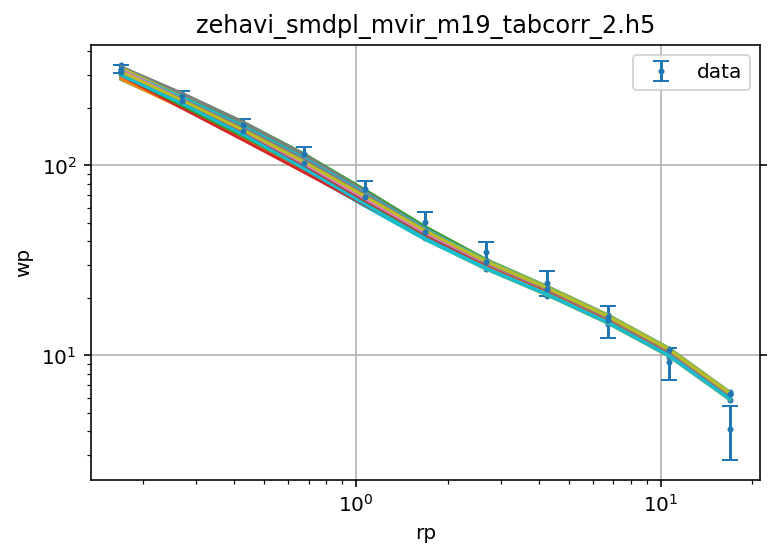

In [29]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
#plt.errorbar(bin_cen,no_wall_wp[0:len(no_wall_wp)],yerr=np.sqrt(no_wall_wp_err),fmt='o',markersize=2,capsize=4,label='no_wall_data')

if param == 'mvir':
    print('mvir')
    cens_occ_model = Zheng07Cens(threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
else:
    print('vmax')
    cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_vmax',threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_vmax', modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
    
#halocat = CachedHaloCatalog(simname='bolshoi',redshift = 0.0)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/Downloads/hlist_1.00231.list.halotools_v0p1.hdf5',update_cached_fname = True)
halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/smdpl.dat.smdpl2.hdf5',update_cached_fname = True)
halocat.redshift = 0.
pi_max = 60.
Lbox = 400.
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
model_instance.populate_mock(halocat)
halotab = TabCorr.read('smdpl_halo_mvir.hdf5')

#param_sampling = [[12.347542986747245, 1.0678928981, 0.0655134025530286, 10.424762610766576, 13.23140384373497]]
#param_sampling = [[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667],[11.604517282462833, 0.5502660775558645, 1.0182266347797018, 10.350843099216723, 12.788228610884667]]
#param_sampling = [[11.83,  0.25, 1., 12.35, 13.08],[11.96,0.38,1.16,10.,13.28],[12.03,0.41,1.07,11.82,13.3]]
#param_sampling = [[12.82,0.75,1.06,8.97,13.83],[12.93,0.74,1.27,13.96-1.7,13.96],[12.03,0.41,1.07,11.82,13.3]]
#param_sampling = [[11.96,0.38,1.16,13.28-1.7,13.28]]
#param_sampling = [[12.42,1.3,1.16,13.28-1.7,13.28]]
#param_sampling = [[12.05,0.7,1.16,13.28-1.7,13.28]]
wp_res = []
for i in range(50):
    
    model_instance.param_dict['logMmin'] = param_sampling[i][0]#Mmin_val[i]
    model_instance.param_dict['sigma_logM'] = param_sampling[i][1]#sigma_val[i]
    model_instance.param_dict['alpha'] = param_sampling[i][2]#alpha_val[i]
    model_instance.param_dict['logM0'] = param_sampling[i][3]#M0_val[i]
    model_instance.param_dict['logM1'] = param_sampling[i][4]#M1_val[i]
   
    ngal, wp = halotab.predict(model_instance)
    
    wp_res.append(wp)
    plt.plot(bin_cen,wp,markersize=2)#,label='Vmax')
#plt.plot(bin_cen,oldfunc,label='Old Corrfunc')
#plt.title("")
plt.legend()
plt.ylabel('wp')
plt.xlabel('rp')
plt.tick_params(right=True)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title(fname)
plt.savefig('wp_plot_'+fname[:-3]+'.png')

In [30]:
print(wp_ng_vals[0],model_instance.mock.number_density)
ht = model_instance.mock.halo_table
N = int(Lbox**3*model_instance.mock.number_density)
N

0.01676 0.014261546875


912739

In [38]:
sort_ht = ht[np.argsort(ht['halo_vmax'])[::-1][0:N]]
sort_ht['halo_vmax'][-1]

152.29

In [5]:
if wp_out_file != None:
    np.save(wp_out_file,wp_res)

# Calculate Chi2 manually to compare to simulation

In [54]:
v=np.load('zehavi_smdpl_vmax_m21_1_wp.npy')
m=np.load('zehavi_smdpl_mvir_m21_2_wp.npy')

In [55]:
def calc_chi2(obs,exp,var):
    chi2s = []
    for wp in obs:
        diff = wp-exp
        chi2 = np.sum(diff**2/var)
        chi2s.append(round(chi2,7))
    return chi2s

In [56]:
chi2s_mvir = calc_chi2(m['wp'],wp_ng_vals[1:len(wp_ng_vals)],err)
chi2s_vmax = calc_chi2(v['wp'],wp_ng_vals[1:len(wp_ng_vals)],err)

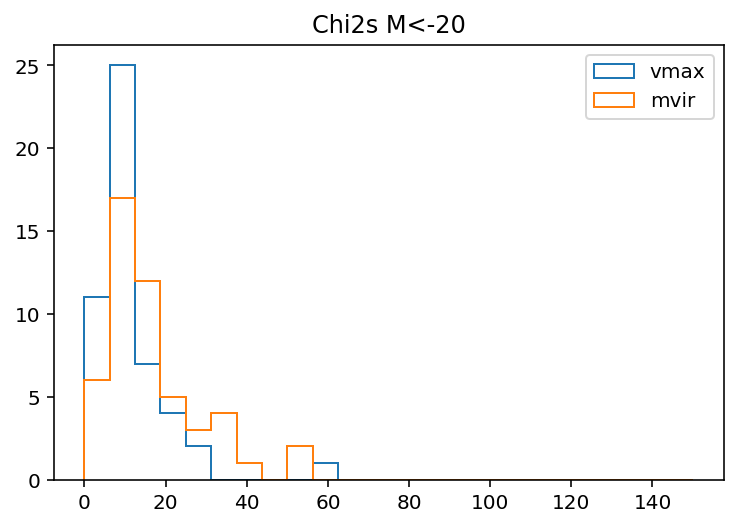

In [57]:
#bins = np.linspace(0,150,25)
plt.hist(chi2s_vmax,bins=bins,histtype='step',label='vmax')
plt.hist(chi2s_mvir,bins=bins,histtype='step',label='mvir')
#plt.axvline(best_vmax_chi2,c='m',label='best emcee vmax x2')
#plt.axvline(best_mvir_chi2,c='r',label='best emcee mvir x2')
plt.title('Chi2s M<-20')
plt.legend()
plt.show()

In [59]:
print('avg chi2/deg: '+ str(round(np.mean(np.array(chi2s_mvir)/7),5)))
print('avg chi2/deg: '+ str(round(np.mean(np.array(chi2s_vmax)/7),5)))

avg chi2/deg: 2.37475
avg chi2/deg: 1.6768


In [60]:
print(min(chi2s_vmax)/7)
print(min(chi2s_mvir)/7)

0.3078745
0.5470570142857143


# Study stochasticity in chi2s of each set of parameters

In [97]:
if param == 'vmax':
    v=np.load('zehavi_smdpl_vmax_m21_1_wp.npy')
else:
    m=np.load('zehavi_smdpl_mvir_m21_2_wp.npy')

In [160]:
print(threshold, param)
unique = []
top_params = []
top_chi2 = chi_per_deg.flatten()[np.argsort(chi_per_deg.flatten())][0:5000]
for i in top_chi2:
    if i not in unique:
        unique.append(i)
        row,col = np.where(chi_per_deg == i)
        top_params.append(list(samples[row,col][0]))
if len(unique)<50:
    top_chi2 = chi_per_deg.flatten()[np.argsort(chi_per_deg.flatten())][5000:10000]
    for i in top_chi2:
        if i not in unique:
            unique.append(i)
            row,col = np.where(chi_per_deg == i)
            top_params.append(list(samples[row,col][0]))
if len(unique)<50:
    top_chi2 = chi_per_deg.flatten()[np.argsort(chi_per_deg.flatten())][10000:15000]
    for i in top_chi2:
        if i not in unique:
            unique.append(i)
            row,col = np.where(chi_per_deg == i)
            top_params.append(list(samples[row,col][0]))
if len(unique)<50:
    top_chi2 = chi_per_deg.flatten()[np.argsort(chi_per_deg.flatten())][15000:20000]
    for i in top_chi2:
        if i not in unique:
            unique.append(i)
            row,col = np.where(chi_per_deg == i)
            top_params.append(list(samples[row,col][0]))

19 mvir


In [161]:
print(len(unique))

522


mvir


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.164 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.722 secs


0.01672303125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.149 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.563 secs


0.016743546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.288 secs


0.016729984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.376 secs


0.016736828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.136 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.806 secs


0.01675825


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.184 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.479 secs


0.016746609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.429 secs


0.0167289375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.122 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.879 secs


0.016734796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.753 secs


0.016729421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.153 secs


0.01672471875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.135 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.715 secs


0.016739359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.882 secs


0.016731765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.637 secs


0.016733515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.697 secs


0.016737234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.122 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.650 secs


0.016750921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.953 secs


0.016746859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.078 secs


0.016761703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.744 secs


0.0167605625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.754 secs


0.016733140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.699 secs


0.0167441875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.140 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.638 secs


0.016733046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.124 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.994 secs


0.016735609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.875 secs


0.01673246875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.622 secs


0.0167369375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.702 secs


0.01673371875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.708 secs


0.0167456875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.652 secs


0.016747046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.125 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.875 secs


0.016724703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.671 secs


0.016728203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.923 secs


0.016731


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.798 secs


0.016753203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.768 secs


0.016735625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.716 secs


0.0167459375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.646 secs


0.016722015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.590 secs


0.016712046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.669 secs


0.016736671875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.773 secs


0.01673475


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.904 secs


0.0167548125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.742 secs


0.01672990625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.669 secs


0.01674475


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.689 secs


0.016745015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.643 secs


0.016725453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.669 secs


0.01674784375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.690 secs


0.016731265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.658 secs


0.016732796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.773 secs


0.0167526875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.659 secs


0.0167531875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.861 secs


0.016738796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.720 secs


0.0167381875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.846 secs


0.016730203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.282 secs


0.01677553125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.202 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.897 secs


0.01677984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.703 secs


0.0167855


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.771 secs


0.016774421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.588 secs


0.016759171875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.718 secs


0.016755234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.626 secs


0.016759890625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.778 secs


0.016775375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.955 secs


0.016786125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.766 secs


0.01677953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.811 secs


0.01675990625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.906 secs


0.016757015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.646 secs


0.016754265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.122 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.654 secs


0.016762140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.733 secs


0.0167703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.744 secs


0.016769140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.794 secs


0.016764703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.173 secs


0.0167656875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.162 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.489 secs


0.016761703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.911 secs


0.016760484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.907 secs


0.016777734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.717 secs


0.016749859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.125 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.745 secs


0.016763421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.220 secs


0.01677040625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.701 secs


0.016767765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.291 secs


0.0167874375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.078 secs


0.016768


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.317 secs


0.0167633125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.722 secs


0.016743265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.907 secs


0.0167565


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.093 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.063 secs


0.016778359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.689 secs


0.016774046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.695 secs


0.016777453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.760 secs


0.01678028125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.126 secs


0.016759875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.136 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.750 secs


0.01675425


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.176 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.720 secs


0.016777015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.719 secs


0.016782296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.722 secs


0.01677653125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.734 secs


0.016765390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.793 secs


0.01677475


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.115 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.849 secs


0.01674971875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.795 secs


0.016770125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.704 secs


0.01678315625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.774 secs


0.016770515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.704 secs


0.01677634375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.673 secs


0.0167594375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.700 secs


0.01676796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.205 secs


0.0167734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.252 secs


0.016748140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.067 secs


0.01676625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.797 secs


0.01676553125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.419 secs


0.0167581875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.146 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.126 secs


0.01674428125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.147 secs


0.016760328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.294 secs


0.016762578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.037 secs


0.0167501875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.577 secs


0.016764453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.193 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 23.621 secs


0.016766265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.167 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.228 secs


0.01677521875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.126 secs


0.016759796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.795 secs


0.016761625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.124 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.631 secs


0.01676771875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.659 secs


0.016778109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.156 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.744 secs


0.016746171875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.135 secs


0.016747640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.382 secs


0.01675021875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.636 secs


0.01677425


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.550 secs


0.01677215625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.128 secs


0.016742421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.332 secs


0.01675496875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.418 secs


0.01674659375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.039 secs


0.016763734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.265 secs


0.016777265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.334 secs


0.01673934375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.125 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.448 secs


0.01676434375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.575 secs


0.0167543125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.548 secs


0.016766265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.407 secs


0.016758875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.478 secs


0.01676628125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.358 secs


0.016750171875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.126 secs


0.016763375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.558 secs


0.016767453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.139 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.479 secs


0.016773859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.269 secs


0.016755953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.545 secs


0.016766609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.116 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.933 secs


0.016762234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.116 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.734 secs


0.016762328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.140 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.430 secs


0.016762484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.124 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.429 secs


0.016750296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.181 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.780 secs


0.01678184375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.444 secs


0.016764375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.724 secs


0.016756703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.675 secs


0.016755875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.225 secs


0.016765890625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.115 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.637 secs


0.01674184375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.710 secs


0.016763484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.967 secs


0.016778140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.815 secs


0.016750796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.897 secs


0.01675475


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.867 secs


0.016786578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.849 secs


0.016768234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.975 secs


0.016765265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.687 secs


0.01677278125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.872 secs


0.01678096875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.879 secs


0.01674565625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.141 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 23.566 secs


0.01677059375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.834 secs


0.01676353125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.633 secs


0.01677559375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.815 secs


0.016783828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.122 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.040 secs


0.0167619375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.672 secs


0.0167994375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.125 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.308 secs


0.016768578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.176 secs


0.016768984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.155 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.727 secs


0.016758515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.194 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.298 secs


0.016778609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.360 secs


0.016752578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.290 secs


0.016760296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.452 secs


0.0167701875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.388 secs


0.01674471875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.634 secs


0.01676546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.081 secs


0.0167931875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.736 secs


0.0167766875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.636 secs


0.016764109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.757 secs


0.016756109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.199 secs


0.016794703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.139 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.206 secs


0.016755453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.231 secs


0.016778109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.116 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.259 secs


0.016784609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.718 secs


0.016767328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.178 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.656 secs


0.016770546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.489 secs


0.016769359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.151 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.325 secs


0.01676590625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.296 secs


0.016735125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.384 secs


0.01678209375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.137 secs


0.016786640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.388 secs


0.016762796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.901 secs


0.01677153125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.448 secs


0.01676353125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.975 secs


0.016770078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.617 secs


0.0167630625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.488 secs


0.0167585


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.410 secs


0.016766765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.818 secs


0.016775265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.124 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.391 secs


0.016788515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.493 secs


0.01678903125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.423 secs


0.016787734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.835 secs


0.01679515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.588 secs


0.016764375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.586 secs


0.0167715625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.381 secs


0.016751515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.281 secs


0.016759546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.184 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.682 secs


0.016762171875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.116 secs


0.016757359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.473 secs


0.01672828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.787 secs


0.0167503125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.717 secs


0.016743421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.167 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.571 secs


0.0167534375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.198 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.797 secs


0.016721453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.242 secs


0.01674646875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.133 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.145 secs


0.0167440625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.817 secs


0.016751953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.620 secs


0.016743703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.225 secs


0.0167510625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.140 secs


0.01675953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.133 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.864 secs


0.01676390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.531 secs


0.01675221875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.154 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.609 secs


0.016740890625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.150 secs


0.0167419375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.176 secs


0.016735296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.173 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.532 secs


0.016742515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.169 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 23.302 secs


0.016753484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.780 secs


0.016748328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.189 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.183 secs


0.01675628125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.403 secs


0.0167520625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.190 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.117 secs


0.016735984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.160 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.461 secs


0.016739734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.166 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.352 secs


0.01674315625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.258 secs


0.0167553125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.181 secs


0.016740625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.141 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.753 secs


0.01675459375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.024 secs


0.0167483125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.139 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.439 secs


0.01674790625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.138 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.256 secs


0.0167453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.608 secs


0.0167436875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.578 secs


0.016746


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.339 secs


0.01674725


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.162 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.253 secs


0.016748515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.139 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.405 secs


0.016748375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.147 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.350 secs


0.016734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.159 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.474 secs


0.016753234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.148 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.394 secs


0.01675921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.366 secs


0.01673915625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.146 secs


0.0167426875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.388 secs


0.0167538125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.575 secs


0.016753625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.246 secs


0.01674890625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.137 secs


0.016728953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.443 secs


0.01673096875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.140 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.087 secs


0.01673571875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.133 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.419 secs


0.01672959375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.278 secs


0.016734859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.388 secs


0.01673684375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.434 secs


0.016742828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.293 secs


0.016752640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.136 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.178 secs


0.016756828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.126 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.355 secs


0.0167475


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.379 secs


0.016751921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.135 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.280 secs


0.0167448125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.638 secs


0.016734953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.152 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.290 secs


0.016754109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.156 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.408 secs


0.01674884375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.151 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.447 secs


0.016755828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.164 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.377 secs


0.016743609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.154 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.335 secs


0.016742234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.157 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.275 secs


0.016730953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.162 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.304 secs


0.016745984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.149 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.200 secs


0.016731828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.280 secs


0.01675484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.345 secs


0.01675028125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.259 secs


0.016738578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.592 secs


0.016744453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.303 secs


0.016759875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.732 secs


0.016738359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.313 secs


0.016733453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.215 secs


0.016737640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.133 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.703 secs


0.016728125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.332 secs


0.0167326875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.435 secs


0.01674046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.314 secs


0.01674009375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.393 secs


0.016753796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.570 secs


0.0167376875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.570 secs


0.01674553125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.809 secs


0.016750109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.166 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.667 secs


0.01674140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.663 secs


0.0167416875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.171 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.764 secs


0.016725359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.414 secs


0.016748890625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 23.510 secs


0.0167335625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.159 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.190 secs


0.01675440625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.154 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.993 secs


0.01675975


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.050 secs


0.016743625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.227 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.771 secs


0.016750640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.158 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.416 secs


0.016755765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.903 secs


0.016751859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.167 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.584 secs


0.01675940625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.157 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.601 secs


0.016729765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.459 secs


0.016739734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.152 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.456 secs


0.016739734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.159 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 26.632 secs


0.01677240625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.269 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 25.764 secs


0.016765921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.231 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 25.475 secs


0.016746109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.165 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.264 secs


0.016771140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.604 secs


0.016767734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.182 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 24.382 secs


0.016742015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.201 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.720 secs


0.016771625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.162 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.933 secs


0.01675503125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.399 secs


0.016731875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.049 secs


0.01674878125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.141 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.762 secs


0.016743625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.415 secs


0.01673496875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.152 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.561 secs


0.016727015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.500 secs


0.0167496875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.152 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.775 secs


0.01674990625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.035 secs


0.01675159375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.143 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.055 secs


0.01676115625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.138 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.008 secs


0.016751140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.140 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.263 secs


0.016753828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.147 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.399 secs


0.01673771875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.490 secs


0.01673809375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.138 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.576 secs


0.016750234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.133 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.265 secs


0.0167534375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.143 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.039 secs


0.016763640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.637 secs


0.0167491875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.953 secs


0.01675346875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.109 secs


0.016754015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.930 secs


0.016746015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.081 secs


0.016749390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.133 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.733 secs


0.016752421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.156 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.554 secs


0.016779640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.135 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.845 secs


0.016750515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.156 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.679 secs


0.0167656875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.133 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.454 secs


0.01676390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.143 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.488 secs


0.0167645


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.767 secs


0.016739609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.168 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.510 secs


0.016757296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.151 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.700 secs


0.016752359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.143 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.848 secs


0.01676090625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.198 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 23.204 secs


0.01677053125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.147 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.399 secs


0.016747796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.175 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.431 secs


0.016727625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.170 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.877 secs


0.016746875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.189 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.665 secs


0.01674284375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.165 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.272 secs


0.016739484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.145 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.104 secs


0.016761359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.163 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.533 secs


0.0167446875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.147 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.643 secs


0.016736046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.145 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.911 secs


0.016741578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.194 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.294 secs


0.0167480625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.174 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.039 secs


0.016749234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.158 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.994 secs


0.0167733125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.116 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.760 secs


0.016790046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.153 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.573 secs


0.016793984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.139 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.473 secs


0.01678340625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.686 secs


0.01678290625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.151 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.570 secs


0.016768140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.225 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 23.524 secs


0.016779921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.564 secs


0.016788796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.148 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.352 secs


0.016766765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.146 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.855 secs


0.016782703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.223 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.048 secs


0.016788859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.163 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.298 secs


0.016768046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.149 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.308 secs


0.01677559375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.139 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.156 secs


0.016790609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.135 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.703 secs


0.01679203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.192 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.763 secs


0.0167884375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.211 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 23.345 secs


0.01679846875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.185 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.852 secs


0.01678621875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.371 secs


0.0167835


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.146 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.699 secs


0.0167806875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.192 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.479 secs


0.0167825625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.165 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.368 secs


0.016770515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.181 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.192 secs


0.01678996875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.152 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.155 secs


0.0167701875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.135 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.070 secs


0.01678828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.138 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.289 secs


0.016790703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.146 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.085 secs


0.016783828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.146 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.214 secs


0.0167776875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.140 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.077 secs


0.01678925


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.373 secs


0.01677803125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.153 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.971 secs


0.0167935625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.149 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.171 secs


0.016779


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.152 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.105 secs


0.016779546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.139 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.182 secs


0.016771359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.174 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.273 secs


0.01680075


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.160 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.086 secs


0.0167738125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.339 secs


0.0167804375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.153 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.213 secs


0.0168006875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.148 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.458 secs


0.016780328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.140 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.051 secs


0.016795578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.199 secs


0.016798828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.327 secs


0.016793734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.157 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.026 secs


0.016775046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.170 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.963 secs


0.01678278125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.184 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.212 secs


0.0167929375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.138 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.621 secs


0.0167875625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 25.251 secs


0.016779203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.188 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 23.470 secs


0.016787015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.158 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.255 secs


0.016784390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.141 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.059 secs


0.016791109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.146 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.665 secs


0.016712859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.689 secs


0.016712625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.401 secs


0.016727


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.916 secs


0.01671959375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.143 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.144 secs


0.016715828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.165 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.443 secs


0.016721765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.163 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.871 secs


0.016737765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.136 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.257 secs


0.0167151875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.406 secs


0.0167215


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.243 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.715 secs


0.016726640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.156 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.333 secs


0.016719359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.645 secs


0.01669921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.138 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.284 secs


0.01670946875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.880 secs


0.016709125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.643 secs


0.01672665625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.170 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.312 secs


0.016722625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.151 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.725 secs


0.01672834375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.416 secs


0.016706203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.166 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.615 secs


0.01672903125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.145 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.320 secs


0.01671271875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.150 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.135 secs


0.01670753125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.153 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.379 secs


0.01670653125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.136 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.442 secs


0.01671734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.164 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.566 secs


0.016720984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.159 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.084 secs


0.016704515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.154 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.731 secs


0.016722828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.176 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.461 secs


0.01673421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.159 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.924 secs


0.0167110625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.419 secs


0.01670925


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.166 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.516 secs


0.016704453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.139 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.715 secs


0.0167229375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.629 secs


0.01672415625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.216 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.780 secs


0.016726984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.155 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.532 secs


0.016717609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.291 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 21.016 secs


0.016714703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.253 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.522 secs


0.01669953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.642 secs


0.01673421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.174 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.385 secs


0.016717109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.908 secs


0.016720296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.785 secs


0.01669246875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.776 secs


0.016694953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.647 secs


0.01670496875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.682 secs


0.016702390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.682 secs


0.01671390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.704 secs


0.0167214375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.611 secs


0.01670453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.999 secs


0.016724


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.775 secs


0.016723546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.726 secs


0.016708390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.662 secs


0.016710390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.845 secs


0.016793296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.787 secs


0.016786125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.819 secs


0.016775109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.160 secs


0.016795296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.211 secs


0.016774078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.904 secs


0.016796265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.095 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.723 secs


0.01678275


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.873 secs


0.01679371875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.794 secs


0.01677865625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.689 secs


0.016779953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.832 secs


0.016800359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.848 secs


0.016776203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.965 secs


0.0167709375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.952 secs


0.016783421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.803 secs


0.01679096875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.836 secs


0.016766796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.801 secs


0.01676575


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.972 secs


0.01677753125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.157 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.779 secs


0.016783203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.816 secs


0.01678765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.761 secs


0.01677603125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.039 secs


0.0167876875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.788 secs


0.016772609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.809 secs


0.016802671875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.752 secs


0.016766953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.794 secs


0.01677946875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.831 secs


0.016784875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.775 secs


0.01676628125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.024 secs


0.01681034375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.929 secs


0.01677753125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.841 secs


0.0167849375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.758 secs


0.016787765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.721 secs


0.016773703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.808 secs


0.016790296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.737 secs


0.01678190625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.771 secs


0.01678221875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.955 secs


0.016791921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.015 secs


0.016787546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.743 secs


0.016780046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.899 secs


0.01679053125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.721 secs


0.0167885


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.885 secs


0.016796984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.382 secs


0.016773484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.336 secs


0.01678453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.274 secs


0.0167841875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.938 secs


0.016784640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.115 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.908 secs


0.0168051875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.821 secs


0.016798109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.696 secs


0.01677175


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.688 secs


0.016784125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.830 secs


0.01673653125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.571 secs


0.0166975


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.899 secs


0.01672196875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.661 secs


0.01672234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.598 secs


0.016709828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.642 secs


0.016728703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.629 secs


0.0167185625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.745 secs


0.01673103125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.737 secs


0.016719234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.709 secs


0.016712515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.720 secs


0.016721734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.693 secs


0.016721578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.619 secs


0.0167095


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.695 secs


0.016719390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.124 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.773 secs


0.016749640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.681 secs


0.01672675


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.661 secs


0.016722921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.124 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.720 secs


0.0167295


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.943 secs


0.016744578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.765 secs


0.0167228125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.657 secs


0.016716890625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.681 secs


0.016722859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.643 secs


0.016700046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.875 secs


0.0166999375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.780 secs


0.01673734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.685 secs


0.016726234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.865 secs


0.01673984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.710 secs


0.016714453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.978 secs


0.01671596875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.949 secs


0.016724140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.627 secs


0.016703921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.776 secs


0.01671775


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.776 secs


0.016721203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.889 secs


0.016732078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.126 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.749 secs


0.016721890625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.652 secs


0.016735125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.667 secs


0.016726359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.622 secs


0.01674834375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.704 secs


0.01672465625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.827 secs


0.01672540625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.893 secs


0.016728984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.769 secs


0.016700109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.624 secs


0.016719359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.683 secs


0.016736015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.623 secs


0.016729421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.650 secs


0.016718796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.692 secs


0.016708359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.707 secs


0.01673509375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.744 secs


0.01673984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.851 secs


0.016710875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.116 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.091 secs


0.016751515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.870 secs


0.016728234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.725 secs


0.01673009375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.709 secs


0.01673946875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.684 secs


0.016725234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.687 secs


0.016748046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.698 secs


0.0167328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.781 secs


0.01672775


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.756 secs


0.016727296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.736 secs


0.016737328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.861 secs


0.01673290625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.116 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.697 secs


0.016715125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.612 secs


0.016725453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.864 secs


0.01675459375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.650 secs


0.016696703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.696 secs


0.01671378125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.842 secs


0.016728984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.725 secs


0.016741578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.637 secs


0.016733421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.793 secs


0.01674715625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.698 secs


0.01674190625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.655 secs


0.016730296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.649 secs


0.016733671875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.609 secs


0.01672715625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.612 secs


0.0167360625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.762 secs


0.016747125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.599 secs


0.01671446875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.769 secs


0.0167444375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.636 secs


0.016733328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.724 secs


0.016740984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.126 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.958 secs


0.016730828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.832 secs


0.01675584375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.116 secs


0.016731109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.115 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.894 secs


0.016733875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.690 secs


0.016736125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.622 secs


0.0167456875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.817 secs


0.01672784375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.700 secs


0.016730375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.128 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.971 secs


0.01674771875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.876 secs


0.016753296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.699 secs


0.016715390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.607 secs


0.01672171875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.125 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.741 secs


0.016735859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.607 secs


0.01673578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.592 secs


0.01672896875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.676 secs


0.016744796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.884 secs


0.016735828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.724 secs


0.01672178125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.648 secs


0.016727296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.790 secs


0.01673271875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.196 secs


0.01679534375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.940 secs


0.01680209375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.074 secs


0.01682034375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.955 secs


0.016809125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.050 secs


0.016818078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.892 secs


0.01680640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.780 secs


0.016802921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.859 secs


0.016811765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.983 secs


0.01681678125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.850 secs


0.01679509375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.922 secs


0.0168180625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.250 secs


0.016811359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.154 secs


0.01683159375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.285 secs


0.0168181875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.366 secs


0.016791234375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.009 secs


0.016798015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.911 secs


0.01680503125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.846 secs


0.01679471875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.890 secs


0.01680575


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.066 secs


0.016810046875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.937 secs


0.0168251875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.919 secs


0.016799484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.852 secs


0.016799921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.980 secs


0.01682415625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.875 secs


0.016815


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.851 secs


0.016801546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.270 secs


0.01681290625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.593 secs


0.0168038125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.312 secs


0.016798734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.366 secs


0.0168104375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.222 secs


0.016791609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.247 secs


0.016830734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.369 secs


0.016787359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.206 secs


0.016822484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.988 secs


0.016788609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.136 secs


0.0168025625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.947 secs


0.01682421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.953 secs


0.016813984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.749 secs


0.016804421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.354 secs


0.016816078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.993 secs


0.01681590625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.068 secs


0.016805015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.956 secs


0.016800984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.122 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.199 secs


0.016803953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.988 secs


0.016826078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.135 secs


0.016796890625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.078 secs


0.016809359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.118 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.940 secs


0.0167931875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.085 secs


0.016816671875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.060 secs


0.01678859375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.067 secs


0.01678959375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.920 secs


0.016809578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.978 secs


0.016799546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.124 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.846 secs


0.016799625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.146 secs


0.016796734375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 20.224 secs


0.016813765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.138 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.716 secs


0.0168088125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.549 secs


0.0167839375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.426 secs


0.016803953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.363 secs


0.016810375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.548 secs


0.0168070625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.156 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.463 secs


0.016792375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.121 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.549 secs


0.01682740625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.394 secs


0.016806484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.448 secs


0.016792875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.831 secs


0.01681709375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.463 secs


0.016787671875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.430 secs


0.016824375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.350 secs


0.016804921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.394 secs


0.0167921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.341 secs


0.016803015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.366 secs


0.01681671875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.467 secs


0.016781703125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.823 secs


0.016789328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.195 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 22.243 secs


0.0168090625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.307 secs


0.01679590625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.796 secs


0.0168065


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.135 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 17.956 secs


0.016790640625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.027 secs


0.016802625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 19.497 secs


0.016818078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.139 sec
0%.........10%.........Received signal = `Interrupt: 2' (signo = 2). Aborting 


RuntimeError: RuntimeError occurred

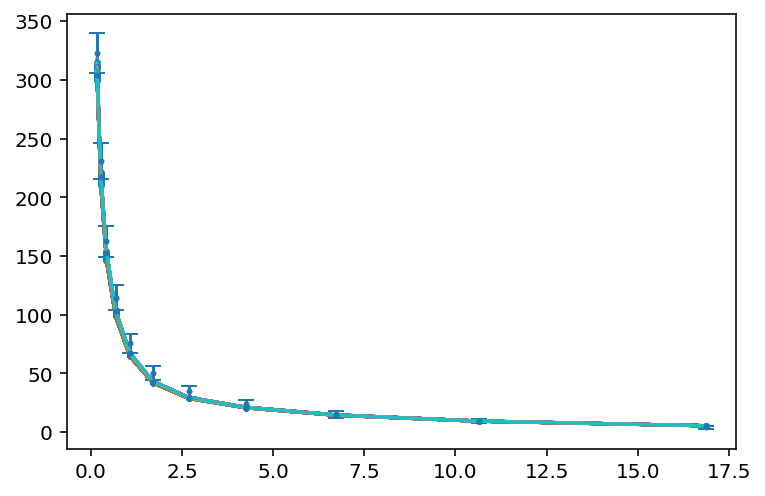

In [162]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
#plt.errorbar(bin_cen,no_wall_wp[0:len(no_wall_wp)],yerr=np.sqrt(no_wall_wp_err),fmt='o',markersize=2,capsize=4,label='no_wall_data')

if param == 'mvir':
    print('mvir')
    cens_occ_model = Zheng07Cens(threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
else:
    print('vmax')
    cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_vmax',threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_vmax', modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
    
#halocat = CachedHaloCatalog(simname='bolshoi',redshift = 0.0)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/Downloads/hlist_1.00231.list.halotools_v0p1.hdf5',update_cached_fname = True)
halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/2019-07-03-18-38-02-9731.dat.my_cosmosim_halos.hdf5')
halocat.redshift = 0.
pi_max = 60.
Lbox = 400.
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
wp_res = np.zeros((50,50,11))
for i in range(50):
    for j in range(50):
    
        model_instance.param_dict['logMmin'] = top_params[i][0]#Mmin_val[i]
        model_instance.param_dict['sigma_logM'] = top_params[i][1]#sigma_val[i]
        model_instance.param_dict['alpha'] = top_params[i][2]#alpha_val[i]
        model_instance.param_dict['logM0'] = top_params[i][3]#M0_val[i]
        model_instance.param_dict['logM1'] = top_params[i][4]#M1_val[i]
   
        try:
            model_instance.mock.populate()
        except:
            model_instance.populate_mock(halocat)
        
        halo_table = model_instance.mock.halo_table
        pos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'], model_instance.mock.galaxy_table['y'],
                                 model_instance.mock.galaxy_table['z'],period = Lbox)
        x = pos[:,0]
        y = pos[:,1]
        z = pos[:,2]
        velz = model_instance.mock.galaxy_table['vz']
        pos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox, velocity=velz, velocity_distortion_dimension='z')
        mod = wp(Lbox,pi_max,1,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2],
                    verbose=True)#,xbin_refine_factor=1, ybin_refine_factor=2, zbin_refine_factor=1)
        #mod = wp(pos_zdist, bin_edges, pi_max, period=Lbox)
        print(model_instance.mock.number_density)
        wp_res[i,j]+=mod['wp']
    
        plt.plot(bin_cen,mod['wp'],markersize=2)#,label='Vmax')
#plt.plot(bin_cen,oldfunc,label='Old Corrfunc')
#plt.title("")
plt.legend()
plt.ylabel('wp')
plt.xlabel('rp')
plt.tick_params(right=True)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

In [149]:
np.save('zehavi_smdpl_vmax_m20_top50wp.npy',wp_res)

In [150]:
mean_wp = []
for i in range(50):
    mean_wp.append(np.mean(wp_res[i],axis=0))

In [151]:
def calc_chi2(obs,exp,var):
    chi2s = []
    for wp in obs:
        diff = wp-exp
        chi2 = np.sum(diff**2/var)
        chi2s.append(round(chi2,7))
        
    return chi2s

In [152]:
avg_chi2s = []
avg_chi2s.append(calc_chi2(mean_wp,wp_ng_vals[1:12],err))

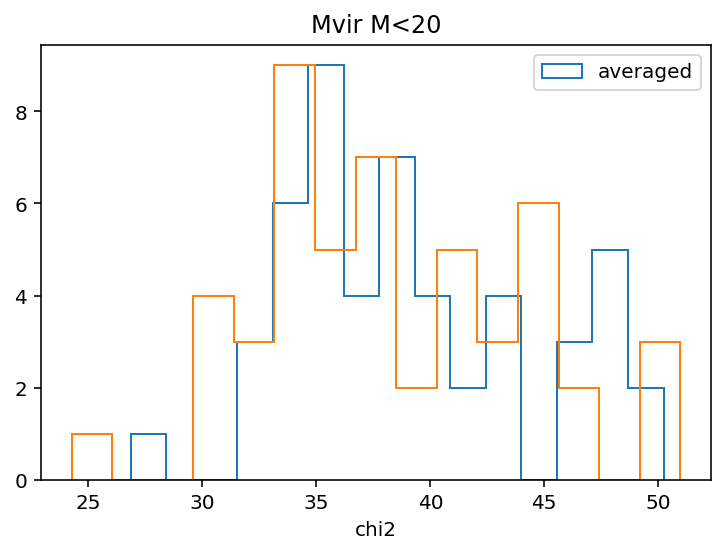

In [153]:
#bins = np.linspace(0,30,25)
bins = 15
plt.hist(avg_chi2s,histtype='step',label='averaged',bins=bins)
plt.hist(calc_chi2(wp_res[:,0,:],wp_ng_vals[1:12],err),histtype='step',bins=bins)
plt.xlabel('chi2')
plt.legend()
plt.title('Mvir M<20')
plt.show()